# Define missingness assumptions for (time-series) dataset
In order to resolve missingness, we need to define assumptions how the missingness is created. We encode these assumptions in a MissingDataGraph that we define here.

__Note__: If the available dataset is fully observed, and you want to inject synthetic missingness, please see `preparation03_missingness_injection` instead. It also saves the ground truth m_graph. 

### Define paths 

In [1]:
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# specifications
data_dir       = "../../../data/ts/" + dataset_name + "/" + miss_scenario + "/" 
data_file          = data_dir + dataset_name + '_' + miss_scenario + '_static.csv.gz' 
temporal_data_file = data_dir + dataset_name + '_' + miss_scenario + '_ts_eav.csv.gz' 
superfeature_mapping_file = data_dir + 'superfeatures.csv'
problem_file   = data_dir + 'problem/' + 'problem.yaml'
afa_problem_files = {
        'action_file'          : data_dir + 'afa_problem/' + 'acquisition_actions.csv', 
        'prediction_cost_file' : data_dir + 'afa_problem/' + 'prediction_cost.csv'
                }

# new specifications (created in this notebook) 
m_graph_adj_file      = data_dir  + 'm_graphs/' + 'm_graph_adjacencies.csv'

# reporting
explanation_file = data_dir  + 'reports/' + 'dataset_description_with_miss_assumption'

### Imports 

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# navigate to afa directory 
sys.path.insert(0, os.path.abspath('../../afa'))

## Load dataset with missingness 
At first, we want to load the dataset (and define the problem)

In [3]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-01-27 04:56:48.354291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 04:56:48.528019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 04:56:48.528041: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-27 04:56:49.224360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
data_loader = DataLoader_ts(       data_file                  = data_file,
                                   temporal_data_file         = temporal_data_file,
                                   superfeature_mapping_file  = superfeature_mapping_file,
                                   problem_file               = problem_file, 
                                   afa_problem_files          = afa_problem_files )
dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 737.94it/s]


## Visualize missingness 
Before specifying assumptions about the missing data process, visualize the missingness

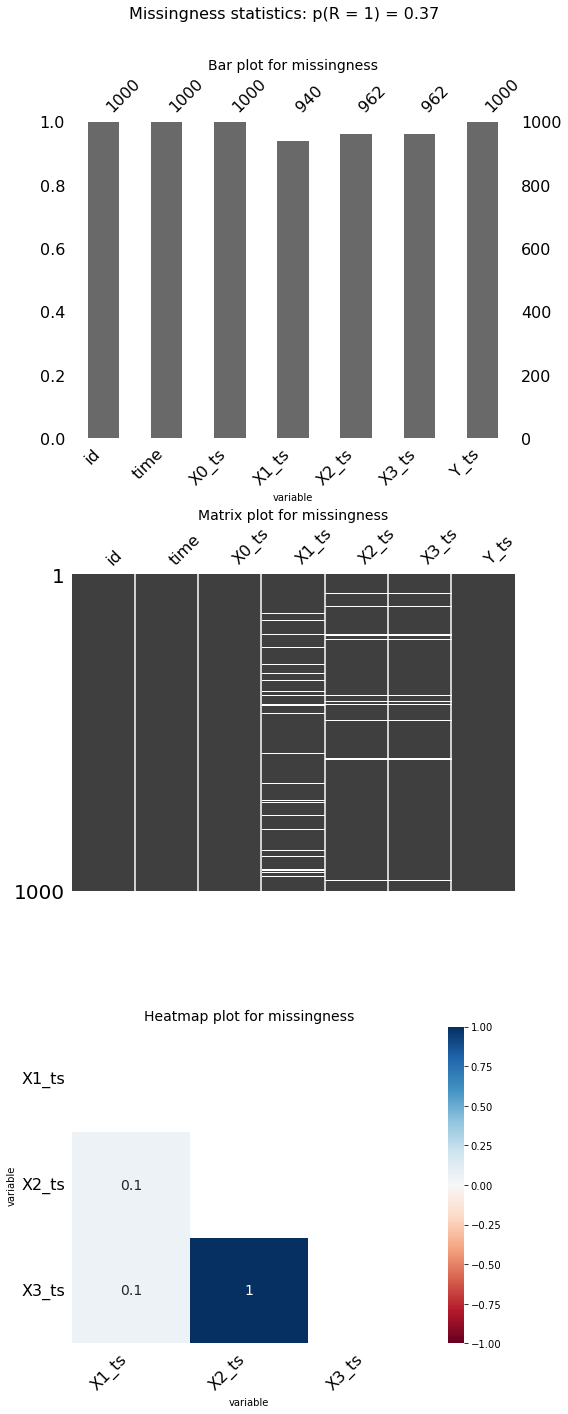

In [5]:
# to do, write code to visualize missingness (e.g. use missingno library) 
fig = dataset.plot_missingness_stats()

In [7]:
dataset.get_data()

(array([[0., 0., 0.]]),
 array([[[0.66854304],
         [1.15254245],
         [0.8090304 ],
         [0.90587518],
         [0.89501303],
         [1.04635655],
         [0.93526224],
         [0.90668519],
         [0.76445211],
         [0.98769683]]]),
 None,
 array([[[ 0.13449869, -0.43060363, -0.42399495, -1.0608998 ],
         [ 1.82220378,  0.01647273, -0.20258768, -0.97652374],
         [ 1.38521766, -0.77247295,  1.2729718 ,  0.0495591 ],
         [ 0.68871806, -0.85096791, -0.51555176,  0.09372807],
         [-0.69750915, -0.09232943, -0.79295377, -0.09396362],
         [-1.25698972,  0.6041184 ,  0.23893399,  0.22720934],
         [ 0.52428602,  1.34561434, -0.83825913, -0.20192945],
         [-1.03528145, -0.66240958, -0.1660076 ,  0.72106368],
         [-1.45207963,  1.31774868,  0.19170324, -0.45640411],
         [ 1.26421295,  0.45028437, -1.98974033,  0.69222894]]]),
 array([[[0],
         [1],
         [2],
         [3],
         [4],
         [5],
         [6],
     

In [7]:
dataset.temporal_data

variable,id,time,X0_ts,X1_ts,X2_ts,X3_ts,Y_ts
0,id_0,0,1.344653,-0.329009,-0.563653,-0.969879,0.823810
1,id_0,1,0.825140,0.772769,0.542344,0.703001,0.746681
2,id_0,2,0.566021,0.481522,0.271774,0.499329,0.931950
3,id_0,3,2.111528,NaN,-1.561965,-1.734246,0.833133
4,id_0,4,0.085852,-0.873108,0.552607,-1.113105,0.848401
...,...,...,...,...,...,...,...
995,id_99,5,-0.485733,-0.144253,1.221359,0.690678,1.005565
996,id_99,6,0.002783,0.581475,-0.858536,1.206425,0.918911
997,id_99,7,-0.367927,0.372796,-1.801247,-1.056743,0.834472
998,id_99,8,-0.994442,-1.356199,-1.536935,0.153399,0.684557


## Define missingness assumptions 

### Option 1: Create missing data assumptions directly via a .csv file
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: name of the features and then name of the superR
- entry(i,j) = 1  
    if node of index i has an arrow to node of column j 

### Option 2: Define the assumptions here and save the mapping 
Define the adjacency matrix of the m_graph using a pandas df

In [8]:
from afa.data_modelling.missingness.missing_data_graph.utils import save_m_graph_adjacency_matrix
import pandas as pd

In [9]:
m_graph_adj = pd.DataFrame([[0, 0], [0, 0]], 
                            index=['X0_ts', 'X1_ts' ], 
                            columns=['R_superX1_ts', 'R_superX2_ts'])

save_m_graph_adjacency_matrix( m_graph_adj , m_graph_adj_file = m_graph_adj_file  )  

## Test by loading missingness model

### Test 1: load missingness model by itself 

In [10]:
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_ts import MissingDataGraph_ts
from afa.data_modelling.missingness.missing_data_graph.utils import load_m_graph_adjacency_matrix
from afa.data_modelling.missingness.missingness_model import MissingnessModel

In [11]:
m_graph_adj = load_m_graph_adjacency_matrix( m_graph_adj_file)

m_graph = MissingDataGraph_ts(m_graph_adj  = m_graph_adj ) 

In [12]:
# visualize adjacency matrix 
m_graph.m_graph_adj

,R_superX1_ts,R_superX2_ts
X0_ts,0,0
X1_ts,0,0


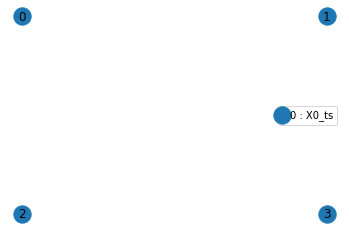

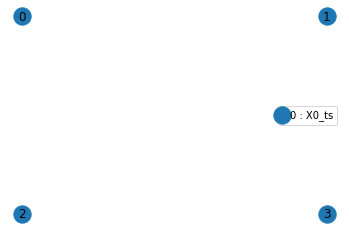

In [13]:
m_graph.plot() 

### Test 2: load missingness model as part of dataset

In [14]:
# define files needed to load missingness model
miss_model_files = {
    'm_graph_adj_file' : m_graph_adj_file, 
    }

In [16]:
data_loader = DataLoader_ts( data_file                  = data_file,
                                 temporal_data_file         = temporal_data_file,
                                 superfeature_mapping_file  = superfeature_mapping_file,
                                 problem_file               = problem_file, 
                                 afa_problem_files          = afa_problem_files, 
                                 miss_model_files           = miss_model_files)
dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 768.85it/s]


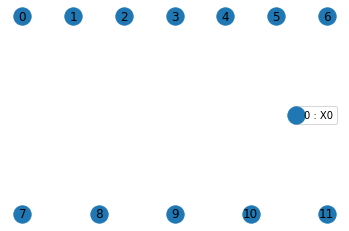

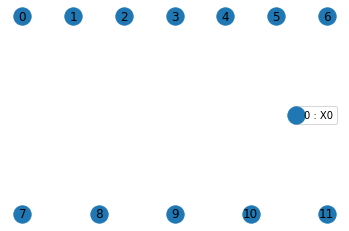

In [17]:
# Visualize the graph
dataset.miss_model.m_graph.plot() 

## Explain the data set and missingness
Store information in reports folder in latex / markdown format that explains the data and the missingness (assumptions)

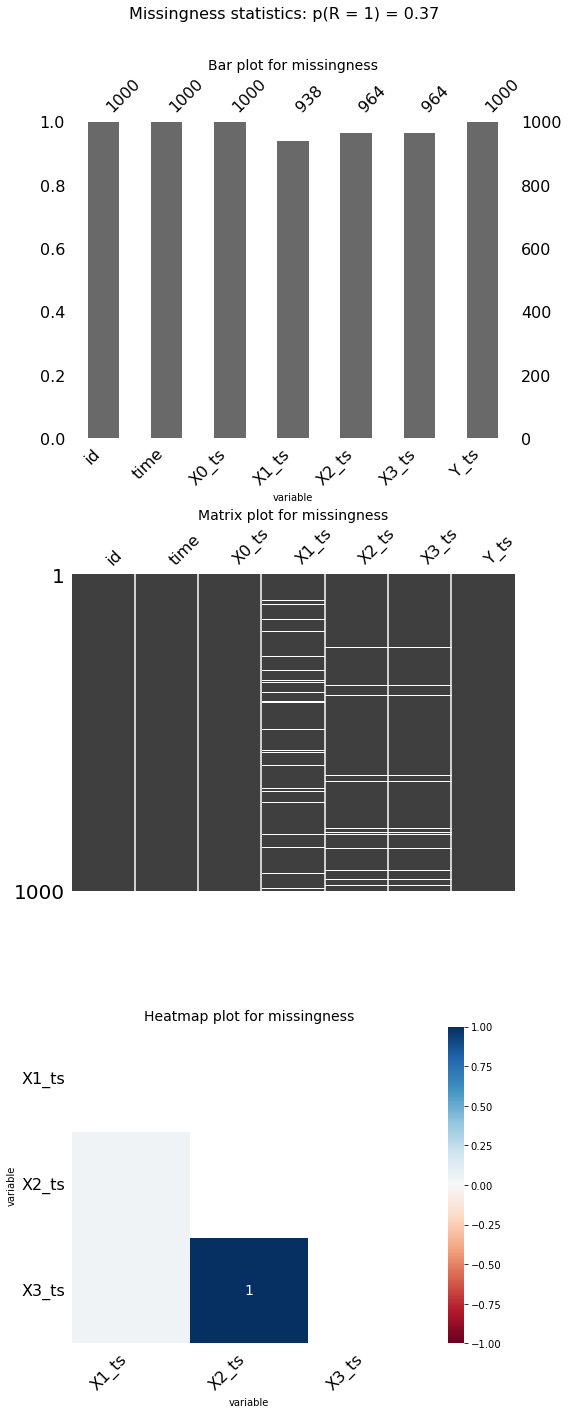

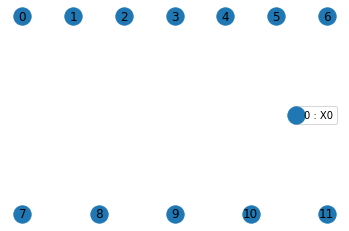

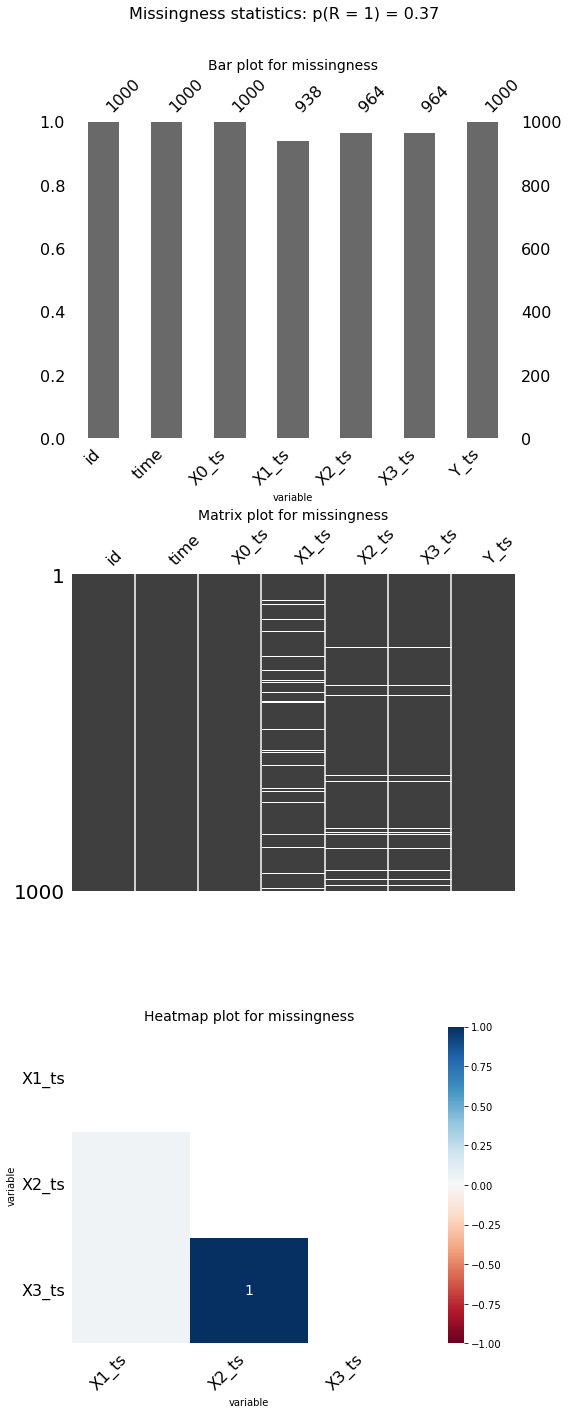

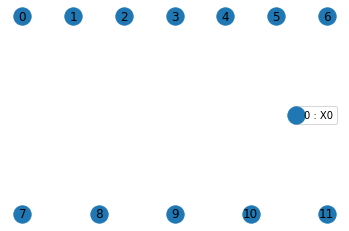

In [18]:
dataset.explain(file=  explanation_file + '.md', format = 'markdown')
dataset.explain(file=  explanation_file + '.tex', format = 'latex')